In [11]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import os


Data Preparation


In [18]:
import os

# Define the path to your dataset
data_dir = r'C:\Users\Hp\Desktop\archive (1)'

# Define image size and batch size
img_height, img_width = 224, 224
batch_size = 32

# Data augmentation and generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # 20% for validation
)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

# Display class indices
print("Class indices:", train_generator.class_indices)


Found 3812 images belonging to 4 classes.
Found 952 images belonging to 4 classes.
Class indices: {'Bacterialblight': 0, 'Blast': 1, 'Brownspot': 2, 'Healthy_rice_plant': 3}


Model Architecture

In [19]:
def se_block(input_tensor, reduction=16):
    """Squeeze-and-Excitation block."""
    channel_axis = -1
    filters = input_tensor.shape[channel_axis]

    se = layers.GlobalAveragePooling2D()(input_tensor)
    se = layers.Reshape((1, 1, filters))(se)
    se = layers.Dense(filters // reduction, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = layers.Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)
    se = layers.multiply([input_tensor, se])
    return se

def dense_block(x, blocks, growth_rate=32):
    """A dense block consisting of multiple convolutional layers."""
    for i in range(blocks):
        y = layers.BatchNormalization()(x)
        y = layers.ReLU()(y)
        y = layers.Conv2D(4 * growth_rate, 1, use_bias=False)(y)
        y = layers.BatchNormalization()(y)
        y = layers.ReLU()(y)
        y = layers.Conv2D(growth_rate, 3, padding='same', use_bias=False)(y)
        x = layers.Concatenate()([x, y])
    return x

def transition_block(x, reduction=0.5):
    """A transition block used between dense blocks."""
    filters = int(x.shape[-1] * reduction)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, 1, use_bias=False)(x)
    x = layers.AvgPool2D(2, strides=2, padding='same')(x)
    return x

def build_model(input_shape=(224, 224, 3), classes=4, growth_rate=32):
    """Build DenseNet model with SE modules."""
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, 7, strides=2, padding='same', use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPool2D(3, strides=2, padding='same')(x)

    # Dense Block 1
    x = dense_block(x, blocks=6, growth_rate=growth_rate)
    x = se_block(x)
    x = transition_block(x, reduction=0.5)

    # Dense Block 2
    x = dense_block(x, blocks=12, growth_rate=growth_rate)
    x = se_block(x)
    x = transition_block(x, reduction=0.5)

    # Dense Block 3
    x = dense_block(x, blocks=24, growth_rate=growth_rate)
    x = se_block(x)
    x = transition_block(x, reduction=0.5)

    # Final BatchNorm and ReLU
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Classification layer
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model

# Build the model
num_classes = len(train_generator.class_indices)
model = build_model(input_shape=(img_height, img_width, 3), classes=num_classes)


Compile the model

In [20]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 112, 112,  │      9,408 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 112, 112,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 56, 56,    │          0 │ re_lu[0][0]       │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ max_pooling2d[0]… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 56, 56,    │      8,192 │ re_lu_1[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        512 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 56, 56,    │     36,864 │ re_lu_2[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 56, 56,    │          0 │ max_pooling2d[0]… │
│ (Concatenate)       │ 96)               │            │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        384 │ concatenate[0][0] │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 56, 56,    │     12,288 │ re_lu_3[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_4 (ReLU)      │ (None, 56, 56,    │          0 │ batch_normalizat

 Total params: 5,023,300 (19.16 MB)

 Trainable params: 4,968,836 (18.95 MB)

 Non-trainable params: 54,464 (212.75 KB)

Train the model

In [8]:
epochs = 50
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)

history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[early_stop, checkpoint]
)


Epoch 1/50


C:\Users\Hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.7047 - loss: 0.7794
Epoch 1: val_loss improved from inf to 3.71556, saving model to best_model.keras
120/120 ━━━━━━━━━━━━━━━━━━━━ 1030s 8s/step - accuracy: 0.7054 - loss: 0.7778 - val_accuracy: 0.3361 - val_loss: 3.7156
Epoch 2/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.8308 - loss: 0.4368
Epoch 2: val_loss improved from 3.71556 to 3.41673, saving model to best_model.keras
120/120 ━━━━━━━━━━━━━━━━━━━━ 1014s 8s/step - accuracy: 0.8309 - loss: 0.4366 - val_accuracy: 0.3550 - val_loss: 3.4167
Epoch 3/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.8926 - loss: 0.2890
Epoch 3: val_loss improved from 3.41673 to 0.71068, saving model to best_model.keras
120/120 ━━━━━━━━━━━━━━━━━━━━ 957s 8s/step - accuracy: 0.8926 - loss: 0.2891 - val_accuracy: 0.7216 - val_loss: 0.7107
Epoch 4/50
120/120 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.9039 - loss: 0.2712
Epoch 4: val_loss improved from 0.71068 to 0.50904, saving model

Evaluate and Visualize

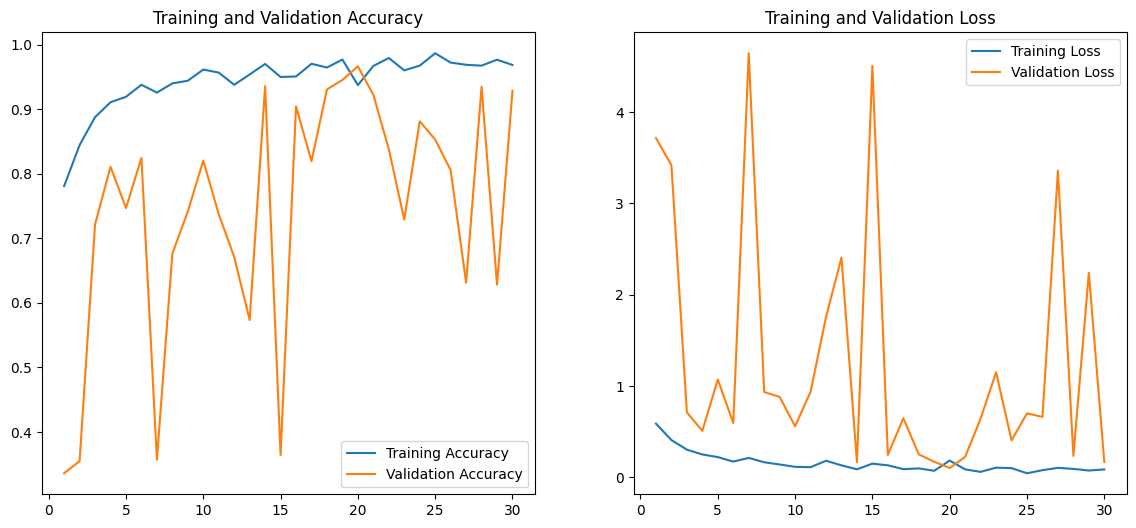

In [9]:
# Plot training and validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(14, 6))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()


In [10]:
import requests
from PIL import Image
from io import BytesIO
import numpy as np
from tensorflow.keras.preprocessing import image

def load_image_from_url(url, target_size=(224, 224)):
    """
    Load and preprocess an image from a URL.
    
    Parameters:
    - url: URL of the image.
    - target_size: Tuple specifying the target size for the image (default is (224, 224)).
    
    Returns:
    - img_array: Preprocessed image array ready for prediction.
    """
    # Send a HTTP GET request to the URL
    response = requests.get(url)
    
    # Open the image from the response content
    img = Image.open(BytesIO(response.content))
    
    # Resize the image to the target size
    img = img.resize(target_size)
    
    # Convert the image to a numpy array
    img_array = image.img_to_array(img)
    
    # Expand dimensions to match the input shape of the model (1, target_size[0], target_size[1], 3)
    img_array = np.expand_dims(img_array, axis=0)
    
    # Normalize the image array
    img_array /= 255.0
    
    return img_array

def predict_image_from_url(url, model, class_indices):
    """
    Load an image from a URL and predict its class using the trained model.
    
    Parameters:
    - url: URL of the image.
    - model: The trained Keras model.
    - class_indices: The dictionary containing class indices.
    
    Returns:
    - predicted_label: The label of the predicted class.
    - confidence: The confidence score of the prediction.
    """
    img_array = load_image_from_url(url)
    
    # Make predictions
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions)
    class_labels = {v: k for k, v in class_indices.items()}  # Reverse the class_indices dict
    predicted_label = class_labels[predicted_class]
    confidence = predictions[0][predicted_class]
    
    return predicted_label, confidence

# Example usage:
url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSe7rgRsmSJoqQyZOHdMxxaz_8YYrXTkAq7pw&s.jpg'  # Replace with the actual URL of the image
predicted_label, confidence = predict_image_from_url(url, model, train_generator.class_indices)

print(f'The predicted label is: {predicted_label} with confidence {confidence:.2f}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
The predicted label is: Healthy_rice_plant with confidence 0.76


In [14]:
import numpy as np
from tensorflow.keras.models import load_model

# Load the saved model from your desktop
model_path = r'C:\Users\Hp\Desktop\rice_disease_detection_model_final1.h5'  # Update this path to where your model is stored
model = load_model(model_path)

def evaluate_model_accuracy(model, data_generator):
    """
    Evaluate the accuracy of the model on the given data generator.
    
    Parameters:
    - model: The trained Keras model.
    - data_generator: The data generator for the dataset to evaluate (e.g., validation data).
    
    Returns:
    - accuracy: The overall accuracy of the model on the dataset.
    """
    # Evaluate the model on the data generator
    loss, accuracy = model.evaluate(data_generator)
    
    print(f'Overall accuracy on the dataset: {accuracy * 100:.2f}%')
    return accuracy

# Example usage with validation data
overall_accuracy = evaluate_model_accuracy(model, validation_generator)



30/30 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - accuracy: 0.9945 - loss: 0.0219
Overall accuracy on the dataset: 98.84%


In [12]:
model.save('rice_disease_detection_model_final3.h5')


In [13]:
import numpy as np
from tensorflow.keras.preprocessing import image

def predict_image(img_path, model, class_indices, img_size=(224, 224)):
    """
    Load and preprocess an image, then predict its class using the trained model.
    
    Parameters:
    - img_path: Path to the image to be predicted.
    - model: The trained Keras model.
    - class_indices: The dictionary containing class indices.
    - img_size: Tuple specifying the target size for the image (default is (224, 224)).
    
    Returns:
    - predicted_label: The label of the predicted class.
    - confidence: The confidence score of the prediction.
    """
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    
    # Make predictions
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions)
    class_labels = {v: k for k, v in class_indices.items()}  # Reverse the class_indices dict
    predicted_label = class_labels[predicted_class]
    confidence = predictions[0][predicted_class]
    
    return predicted_label, confidence

# Example usage:
img_path = r'C:\Users\Hp\Desktop\archive (1)\Bacterialblight\BACTERAILBLIGHT3_064.jpg'  # Update this path with the actual image path
predicted_label, confidence = predict_image(img_path, model, train_generator.class_indices)

print(f'The predicted label is: {predicted_label} with confidence {confidence:.2f}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
The predicted label is: Bacterialblight with confidence 1.00
